Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Load Labeled DF

In [ ]:
main_df = pd.read_csv('/content/drive/MyDrive/AMIGOS/Exp2_DF_Labeled.csv')

In [ ]:
main_df

,frame,face_id,timestamp,confidence,success,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,dominance,liking,familiarity,neutral,disgust,happiness,surprise,anger,fear,sadness
0,3,0,0.08,0.98,1,-0.385125,0.134773,-0.912970,-0.492953,0.132330,...,4.76,8.12,2.36,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,0.08,0.98,1,0.274001,0.025506,-0.961391,0.141810,0.033585,...,3.32,7.80,2.36,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,3,2,0.08,0.88,1,0.756852,0.231358,-0.611268,0.664592,0.245878,...,4.28,5.64,9.00,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,3,3,0.08,0.88,1,-0.143009,0.317884,-0.937282,-0.285699,0.318995,...,7.56,7.88,1.40,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6,0,0.20,0.98,1,-0.384993,0.134877,-0.913010,-0.492941,0.132440,...,4.76,8.12,2.36,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794837,21276,3,851.00,0.93,1,0.097215,-0.109715,-0.989198,-0.012894,-0.136827,...,5.88,7.80,1.96,0.0,0.0,1.0,0.0,0.0,0.0,1.0
794838,21279,0,851.12,0.98,1,0.493929,0.020739,-0.869255,0.376686,0.027592,...,3.24,8.12,1.32,0.0,0.0,1.0,0.0,0.0,0.0,1.0
794839,21279,1,851.12,0.98,1,-0.068890,-0.041851,-0.996746,-0.217434,-0.026081,...,6.36,6.04,6.36,1.0,0.0,1.0,0.0,0.0,0.0,1.0
794840,21279,2,851.12,0.98,1,-0.301181,0.036381,-0.952873,-0.429786,0.021777,...,2.60,8.36,2.28,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# **Models**

Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
import pickle
from keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall

Thresholding all the labels

In [ ]:
# Thresholding the 'arousal' column
main_df['arousal_bin'] = (main_df['arousal'] >= 4.5).astype(int)
Counter(main_df['arousal_bin'])

Counter({1: 606169, 0: 188673})

In [ ]:
# Thresholding the 'valence' column
main_df['valence_bin'] = (main_df['valence'] >= 4.5).astype(int)
Counter(main_df['valence_bin'])

Counter({1: 494792, 0: 300050})

In [ ]:
# Thresholding the 'dominance' column
main_df['dominance_bin'] = (main_df['dominance'] >= 4.5).astype(int)
Counter(main_df['dominance_bin'])

Counter({1: 356726, 0: 438116})

In [ ]:
# Thresholding the 'liking' column
main_df['liking_bin'] = (main_df['liking'] >= 4.5).astype(int)
Counter(main_df['liking_bin'])

Counter({1: 652215, 0: 142627})

Re-Arranging the columns

In [ ]:
main_df.iloc[:, 5:-17]

,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,eye_lmk_x_0,eye_lmk_x_1,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,-0.385125,0.134773,-0.912970,-0.492953,0.132330,-0.859934,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.274001,0.025506,-0.961391,0.141810,0.033585,-0.989324,0.210,0.030,434.0,435.2,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.756852,0.231358,-0.611268,0.664592,0.245878,-0.705593,0.824,0.348,156.8,158.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.143009,0.317884,-0.937282,-0.285699,0.318995,-0.903669,-0.229,0.333,753.6,754.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.384993,0.134877,-0.913010,-0.492941,0.132440,-0.859923,-0.460,0.150,1082.8,1083.9,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794837,0.097215,-0.109715,-0.989198,-0.012894,-0.136827,-0.990511,0.043,-0.124,447.8,449.7,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
794838,0.493929,0.020739,-0.869255,0.376686,0.027592,-0.925930,0.452,0.027,121.7,122.9,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
794839,-0.068890,-0.041851,-0.996746,-0.217434,-0.026081,-0.975727,-0.144,-0.034,723.3,724.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
794840,-0.301181,0.036381,-0.952873,-0.429786,0.021777,-0.902668,-0.375,0.031,1062.9,1064.2,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


Features

In [ ]:
# Features (all columns except the last 13)
X = main_df.iloc[:, 5:-17].values

In [ ]:
X

array([[-0.385125,  0.134773, -0.91297 , ...,  1.      ,  1.      ,
         0.      ],
       [ 0.274001,  0.025506, -0.961391, ...,  1.      ,  1.      ,
         1.      ],
       [ 0.756852,  0.231358, -0.611268, ...,  1.      ,  1.      ,
         0.      ],
       ...,
       [-0.06889 , -0.041851, -0.996746, ...,  0.      ,  0.      ,
         1.      ],
       [-0.301181,  0.036381, -0.952873, ...,  0.      ,  1.      ,
         1.      ],
       [ 0.092577, -0.119303, -0.988532, ...,  0.      ,  0.      ,
         1.      ]])

Normalizing the Features

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

array([[-1.46275723,  0.19533889,  0.11783669, ...,  2.45966901,
         0.99654616, -1.02236255],
       [ 0.65787908, -0.47129481, -0.48537572, ...,  2.45966901,
         0.99654616,  0.97812659],
       [ 2.21137774,  0.7846002 ,  3.87633796, ...,  2.45966901,
         0.99654616, -1.02236255],
       ...,
       [-0.44531986, -0.88223723, -0.92581633, ..., -0.40655877,
        -1.00346581,  0.97812659],
       [-1.19268035, -0.40494686, -0.37926136, ..., -0.40655877,
         0.99654616,  0.97812659],
       [ 0.07417532, -1.35476886, -0.8234891 , ..., -0.40655877,
        -1.00346581,  0.97812659]])

In [ ]:
len(X_scaled[0])

709

Applying PCA

In [ ]:
# Apply PCA
pca = PCA(n_components=0.999)  # Retain 99.9% variance
X_pca = pca.fit_transform(X_scaled)

In [ ]:
len(X_pca[10])

71

In [ ]:
# Check explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained variance retained: {explained_variance * 100:.2f}%")

Explained variance retained: 99.90%


In [ ]:
# Output the reduced dataset
print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")

Original shape: (794842, 709)
Reduced shape: (794842, 71)


## **ANN Combined Model**
### **All Labels: Arousal, Valence, Dominance, Liking**

In [ ]:
# Use all four labels (arousal, valence, dominance, liking)
y = main_df[['arousal_bin', 'valence_bin', 'dominance_bin', 'liking_bin']].values  # Binary classification for all labels

In [ ]:
y

array([[1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 0, 0, 1],
       ...,
       [0, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1]])

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [ ]:
X_train

array([[ 11.9300839 , -17.60886481,  13.56151083, ...,  -0.81886102,
         -0.13994202,  -0.1819577 ],
       [  7.26696586,  10.18823174,  -0.45652345, ...,   0.03468289,
         -0.07370913,  -0.13982535],
       [  7.26307734,  12.36100519,   5.2381857 , ...,   0.20595778,
         -0.2392185 ,   0.12590584],
       ...,
       [ 10.96842159, -15.63031544,   9.64572114, ...,  -0.18606772,
          0.83156792,  -0.95443905],
       [ 11.77145124, -17.75633284,   9.06669213, ...,  -0.09804896,
         -0.20568523,  -0.17608556],
       [  9.56154698,  -5.15735908,   0.6546081 , ...,  -0.08903095,
         -0.1667219 ,   0.07427969]])

In [ ]:
y_train

array([[1, 1, 0, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       ...,
       [1, 1, 0, 1],
       [1, 0, 0, 1],
       [1, 1, 1, 1]])

In [ ]:
X_train.shape

(635873, 71)

In [ ]:
y_train.shape

(635873, 4)

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, K.floatx())
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t + K.epsilon())
        return K.mean(loss)
    return loss

In [ ]:
# Define the model
model = Sequential([
    # Layer 1
    Dense(1024, activation=None, input_dim=X_train.shape[1]),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Layer 2
    Dense(512, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Layer 3
    Dense(256, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Layer 4
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Layer 5
    Dense(128, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    # Layer 6
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Layer 7
    Dense(64, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Layer 8
    Dense(32, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Layer 9
    Dense(32, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    # Output layer 10 (4 units for 4 labels)
    Dense(4, activation='sigmoid')  # Sigmoid for binary multi-label classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # Adaptive learning rate optimizer
              loss='binary_crossentropy',
              # loss=focal_loss(gamma=1.5, alpha=0.25),  # Suitable for binary multi-label classification
              metrics=['accuracy', Precision(), Recall()])

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop training if no improvement in 3 epochs
    restore_best_weights=True  # Restore the best weights after stopping
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half
    patience=2,  # Trigger after 2 epochs of no improvement
    min_lr=1e-6  # Set a lower bound for the learning rate
)

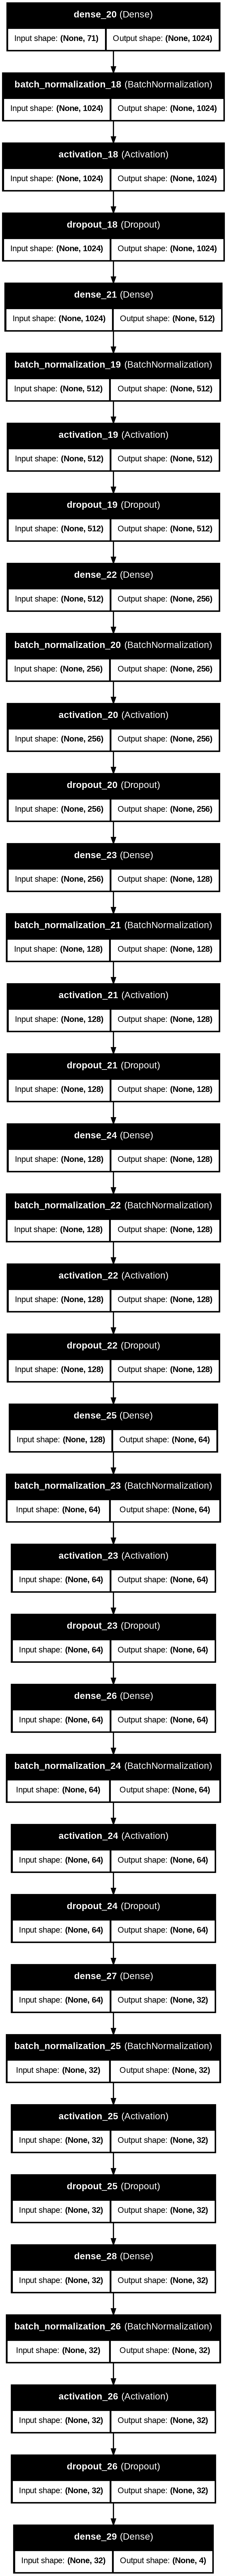

In [ ]:
# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model with mini-batches
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),  # Use a validation set for monitoring
    epochs=20,  # Set a high epoch count to leverage early stopping
    batch_size=512,  # Use mini-batches for efficient training
    callbacks=[early_stopping, reduce_lr],  # Apply callbacks
    verbose=1  # Show training progress
)

Epoch 1/15
1242/1242 [==============================] - 57s 44ms/step - loss: 0.2375 - accuracy: 0.4527 - precision_10: 0.9138 - recall_10: 0.9388 - val_loss: 0.0729 - val_accuracy: 0.4776 - val_precision_10: 0.9780 - val_recall_10: 0.9822 - lr: 0.0010
Epoch 2/15
1242/1242 [==============================] - 53s 43ms/step - loss: 0.1114 - accuracy: 0.4594 - precision_10: 0.9701 - recall_10: 0.9717 - val_loss: 0.0517 - val_accuracy: 0.4695 - val_precision_10: 0.9843 - val_recall_10: 0.9872 - lr: 0.0010
Epoch 3/15
1242/1242 [==============================] - 53s 43ms/step - loss: 0.0873 - accuracy: 0.4759 - precision_10: 0.9774 - recall_10: 0.9781 - val_loss: 0.0427 - val_accuracy: 0.4181 - val_precision_10: 0.9864 - val_recall_10: 0.9895 - lr: 0.0010
Epoch 4/15
1242/1242 [==============================] - 53s 43ms/step - loss: 0.0760 - accuracy: 0.4887 - precision_10: 0.9805 - recall_10: 0.9809 - val_loss: 0.0364 - val_accuracy: 0.3911 - val_precision_10: 0.9898 - val_recall_10: 0.9896 -

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels
y_true = y_test  # True class labels

4968/4968 [==============================] - 10s 2ms/step


In [ ]:
# Define label names
label_names = ['Arousal', 'Valence', 'Dominance', 'Liking']

In [ ]:
# Initialize an empty list to store accuracies
label_accuracies = []

# Loop through each label (column)
for i in range(y_true.shape[1]):
    acc = accuracy_score(y_true[:, i], y_pred_classes[:, i])  # Calculate accuracy for each label
    label_accuracies.append(acc)

# Display the per-label accuracies
for i, acc in enumerate(label_accuracies):
    print(f"Accuracy for {label_names[i]}: {acc * 100:.2f}%")

Accuracy for Arousal: 99.05%
Accuracy for Valence: 98.90%
Accuracy for Dominance: 99.22%
Accuracy for Liking: 99.63%


In [ ]:
# Metrics
f1 = f1_score(y_test, y_pred_classes, average='micro')
print(f"F1 Score (Micro): {f1:.2f}")

F1 Score (Micro): 0.99


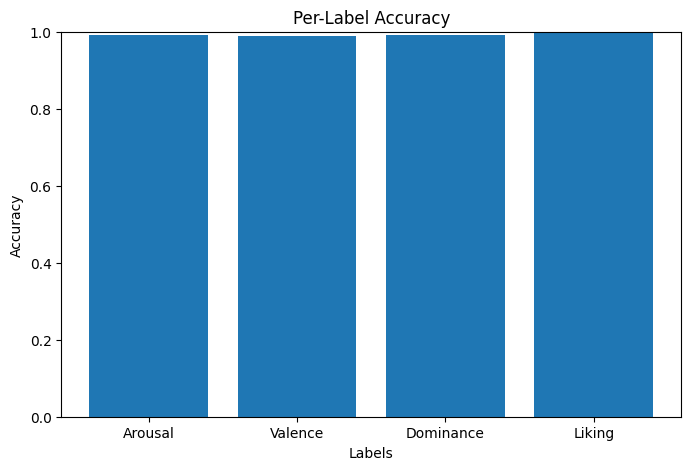

In [ ]:
# Plot bar chart for label accuracies
plt.figure(figsize=(8, 5))
plt.bar(range(len(label_accuracies)), label_accuracies, tick_label=label_names)
plt.title('Per-Label Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Labels')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

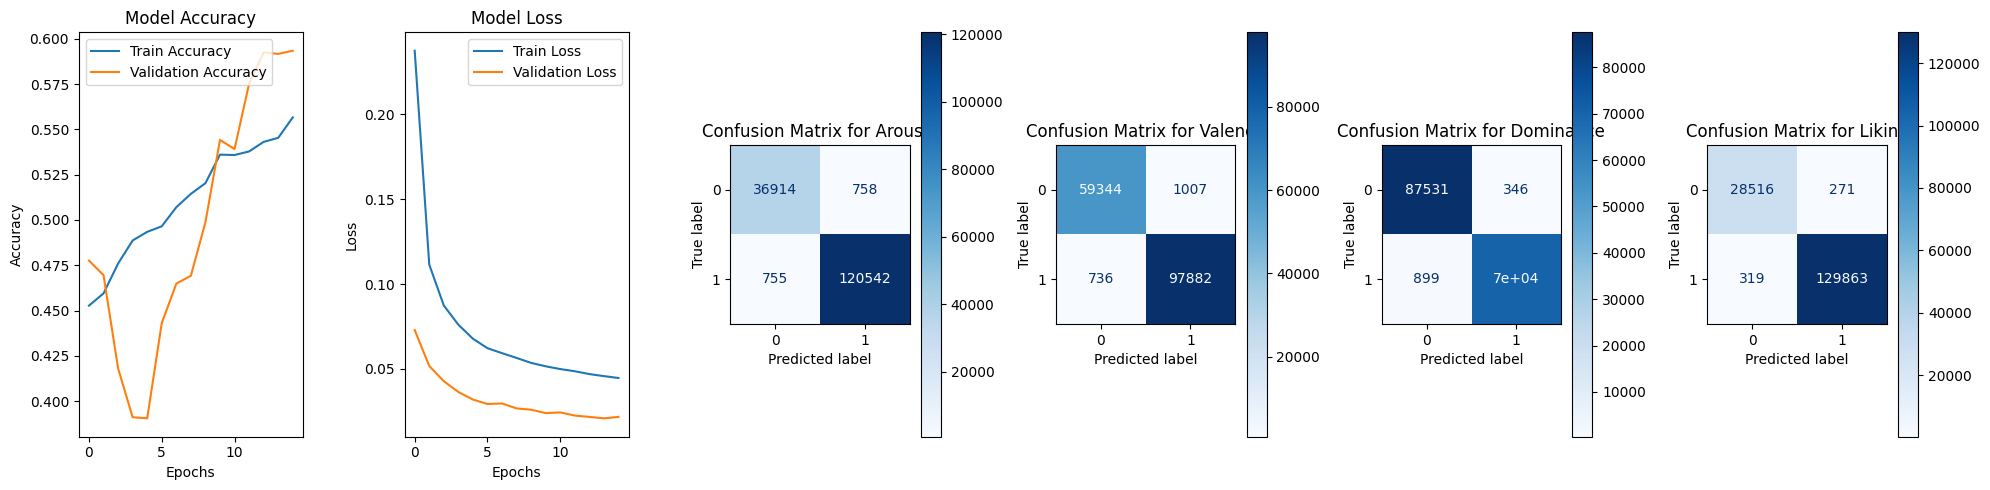

In [ ]:
# Create subplots: 1 row, 6 columns to accommodate all 4 labels and 2 for accuracy/loss plots
fig, ax = plt.subplots(1, 6, figsize=(20, 5))  # Adjusted to fit 6 subplots

# Plot training & validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training & validation loss
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Compute confusion matrices for each label independently
for i in range(y_pred_classes.shape[1]):  # Iterate over each label (4 labels)
    cm = confusion_matrix(y_true[:, i], y_pred_classes[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])  # Binary class labels
    disp.plot(ax=ax[i+2], cmap="Blues")  # Now you have enough subplots
    ax[i+2].set_title(f'Confusion Matrix for {label_names[i]}')  # Set label name for each plot

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Save / Load Model

In [ ]:
# Save the model using pickle
with open('/content/drive/MyDrive/AMIGOS/emotions_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Load the model from the .pkl file
with open('/content/drive/MyDrive/AMIGOS/emotions_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Check the model summary to verify
loaded_model.summary()